In [8]:
# basic packages
import re
import numpy as np 
import pandas as pd 
import sys
sys.path.append("/home/pavithra/projects/NLP/ml_utils/kaggle_utils.py")
import kaggle_utils as utils 

# visualization packages
import plotly.graph_objects as go

# NLP framework
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
import gensim

# model preprocessing and metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.callbacks import EarlyStopping


2024-05-02 21:59:43.529063: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-05-02 21:59:43.529085: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1 | Basic stuffs


In [9]:

# Get the data
file_path: str = "data/train.csv"
data = pd.read_csv(file_path)
data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
column, categorical_data, numerical_data, missing_data = utils.Common_data_analysis(data)

======================================= Common data analysis =======================================

Numerical data list ['id', 'target'] ---> total 2 numerical values
Categorical data list ['keyword', 'location', 'text'] ---> total 3 categorical values



,data type,Missing Value(NA),?[]na null ' ',% of Missing value(NA),% of Missing value(?[]na null ' ')
id,int64,0,0,0.000000,0.000000
keyword,object,61,0,0.800000,0.000000
location,object,2533,4,33.270000,0.050000
text,object,0,0,0.000000,0.000000
target,int64,0,0,0.000000,0.000000


In [11]:
# target value analysis
x, y = data.iloc[:, :-1], data.iloc[:, -1]
print(f"Number of values in train X -----------> {len(x)}")
print(f"Number of values in train y -----------> {len(y)}")

Number of values in train X -----------> 7613
Number of values in train y -----------> 7613


In [12]:
# check the distribution of target values.
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        y = y,
        ybins = dict(size = 0.5),
        marker_color= '#9900cc',
        histnorm='percent'
    )
)

fig.update_layout(
    template = "plotly_dark",
    title = "Customer profile count -- training data",
    yaxis_title = "Number of months",
    bargap = 0.2
)

fig.show()

# percentage of the target split
target_0 = y[y == 0]
target_1 = y[y == 1]
target_0_percentage = (len(target_0) / len(y)) * 100
target_1_percentage = (len(target_1) / len(y)) * 100
print(f"percentage of the target 0 (not disaster ) --> {target_0_percentage}")
print(f"percentage of the target 1 (real disaster ) --> {target_1_percentage}")


# Not a big difference we can use as it is for classification.

percentage of the target 0 (not disaster ) --> 57.03402075397347
percentage of the target 1 (real disaster ) --> 42.96597924602653


# 2 | Data preprocessing

In [13]:
# feature selection
# data preprocessing
# feature transformation
# word vectorization
# hyperparameter tuning - automl
# training -- dl, using rnn and lstm



# 1 | feature selection
# id - is just a index we can remove it too.
# location has 33% missing values and in tweet classification this is not gonna add much values -- gonna drop this feature
# keyword has 0.8% missing values gonna fill the missing values with NA.
def handle_missing_value_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    * Drop the features which has missing values and not useful.
    * Fill the missing values of the "Keyword" feature with "NA" text.
    """
    df = df.drop(["location","id"], axis=1)
    df = df.fillna("NA")
    return df

# 2 | feature transformation (basic preprocessing of words)
# converting the Keyword feature to text -- it just has 8 unique value -- so converting to number is fine
def feature_ordinal_encoding(df: pd.DataFrame, column_name: str, ordinal_encoding, fit_transform = True) -> pd.DataFrame:
    """ 
    Do the ordinal encoding for the given feature name.

    :param df: The dataframe.
    :param column_name: The column name to apply ordinal encoding.
    :param ordinal_encoding: sklearn ordinal encoder object.
    :param fit_transform: If true, it will fit and transform. if False just transform(for test data)
    """
    if fit_transform:
        df[column_name] = ordinal_encoding.fit_transform(df[[column_name]])
    else:
        df[column_name] = ordinal_encoding.transform(df[[column_name]])
        
    # the value returned is in float, converting to int
    df[column_name] = df[column_name].astype("int64")

    return df


# can i remove punctuation: yes i have to
# can i remove links: yes it is not gonna give any useful information here
# can i remove numbers: yes, we can because "2 people died through the disaster" and  "people died through the disaster" are both gonna give the same meaning.
# can i remove stop words: yes, we can.
from nltk.corpus import stopwords



# tokonization
def tokenoizer(data: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """ 
    * 1 | remove the punctuation words and symbols.
    * 2 | remove any link.
    * 3 | remove numbers.
    * 4 | case fold -- change it to lower case.
    * 5 | tokenize.
    * 6 | remove stop words.
    """
    df = pd.DataFrame()
    # 1 | remove the punctuation words and symbols and numbers.
    # will create a regex and apply over the text.
    df["clean_data"] = data[column_name].apply(lambda s: re.sub(r"[.,!?:;-='...\"@#_><@#$%&*(){}\[\]\/\\/]", " ", s)) # consider using this next time 0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~

    # 2 | remove any link.
    df["clean_data"] = df["clean_data"].apply(lambda s: re.sub(r"(w+://S+)", " ", s))

    # 3 | remove numbers.
    df["clean_data"].replace('d+', '', regex=True, inplace=True)

    # 4 | case fold -- change it to lower case.
    df["clean_data"] = df["clean_data"].str.lower()

    # 5 | tokenize.
    tokenoizer: TweetTokenizer = TweetTokenizer()
    df["clean_data"] = df["clean_data"].apply(lambda x: tokenoizer.tokenize(x))

    # 5 | remove stop words.
    def remove_stop_word(words: list) -> list:
        """  
        Remove the stop words from the list of words.
        """
        stop_words = stopwords.words('english')
        return [word for word in words if word not in stop_words]
    
    df["clean_data"] = df["clean_data"].apply(lambda words: remove_stop_word(words))

    return df


# can be done easily using spacy -- but less control over it
# def spacy_tokenizer(doc):
#   return [t.lemma_.lower() for t in nlp(doc) if \
#           len(t) > 2 and \
#           not t.is_punct and \
#           not t.is_space and \
#           not t.is_stop and \
#           t.is_alpha]
# tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')


def lemmatization(df: pd.DataFrame, column_name) -> pd.DataFrame:
    """ 
    Do lemmatizarion on the tokens in all the rows.
    """

    def create_lemma(words: list):
        """ 
        Create the lemma for the list of string.
        """
        lemmetizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmetizer.lemmatize(token) for token in words]
        return lemmatized_tokens
    
    df[column_name] = df[column_name].apply(lambda row: create_lemma(row))

    return df


In [14]:
x = handle_missing_value_features(x)
ordinal_encoding = OrdinalEncoder()
x = feature_ordinal_encoding(x, column_name="keyword", ordinal_encoding=ordinal_encoding)
text = x[["text"]].copy()
df = tokenoizer(text, "text")
df = lemmatization(df, "clean_data")
x["text"] = df["clean_data"]


In [15]:
x["text"] = df["clean_data"]
x.head()

,keyword,text
0,0,"[dees, reason, earthquake, may, allah, forgive..."
1,0,"[forest, fire, near, la, ronge, sask, canaa]"
2,0,"[resients, aske, shelter, place, notifie, offi..."
3,0,"[13, 000, people, receive, wilfires, evacuatio..."
4,0,"[got, sent, photo, ruby, alaska, smoke, wilfir..."


# 3 | Word2vec (Word embedding)


From the source code:

- **fit_on_texts** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).


- **texts_to_sequences** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.


Why don't combine them? Because you almost always fit once and convert to sequences many times. You will fit on your training corpus once and use that exact same word_index dictionary at train / eval / testing / prediction time to convert actual text into sequences to feed them to the network. So it makes sense to keep those methods separate.

In [16]:
# First converting the tokens into corresponding numbers.
tokenizer = keras.preprocessing.text.Tokenizer(num_words=100000,
                                               lower=True)
# give the tweets texts to the models and fit the texts.
tokenizer.fit_on_texts(x["text"])
X_train = tokenizer.texts_to_sequences(x["text"])


In [17]:
X_train[0]

[4262, 467, 197, 75, 1475, 4263, 9]

In [18]:
[tokenizer.index_word[x] for x in X_train[0][:8]]

['dees', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

In [19]:
# Review excerpt reconstructed from integer sequence.
tokenizer.sequences_to_texts([X_train[0]])[0][:300]
x["text"][0]

['dees', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']

In [20]:
# need to pad the sequence -- need to find the maximum length of the tweets
# df_length = pd.DataFrame()
# df_length["length"] = x["text"].apply(lambda x: len(x))
# max_length = df_length["length"].max()

# print("max length of the tweets --->", max_length)
# del df_length


# output is
# max length of the tweets ---> 30

# i can pad my sentences upto 40, just to have little extra.

X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=40)
print(X_train[0])


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 4262  467  197   75 1475 4263    9]


In [21]:
# # basic methods of word_vectors:
# try:
#   word_vectors['womblyboo']
# except KeyError as e:
#   print(e)
# print(word_vectors.similarity('pizza', 'tomato'))
# word_vectors.n_similarity("martian dolphins are hostile".split(), "i flunked calligraphy school".split())
# word_vectors.doesnt_match(["apple", "orange", "hamburger", "banana", "kiwi"]) # --find odd one out.

In [22]:
# importing the pre-build word2vec by google. 
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('/home/pavithra/projects/NLP/GoogleNews-vectors-negative300.bin', binary=True,)

# This represents each word in a vector of 300 length.

# The following step creates a (n_token * 300) matrix -- where in the word index generated by the keras tokenizor we will be having the google word2vec model word vectors.
# tokeniser's index for a word "am" is 1
# then the matrix will have
# [
# [0,0,0,0,0,...]
# [0.12313, 0.4124, -0.24124, 0.4124,...] # this will be in 300 length representing the word "is"
# ]

# + 1 to account for padding token. 0 is always reserved for padding in enbedding layer.
num_tokens = len(tokenizer.word_index) + 1

# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word_vectors.has_index_for(word):
    embedding_matrix[i] = word_vectors[word].copy()

In [23]:
# we check one word
print(embedding_matrix[tokenizer.word_index['male']][:50])

[-0.06787109  0.09228516 -0.02209473 -0.17382812 -0.10253906 -0.17675781
 -0.04443359  0.07568359  0.07910156  0.02368164 -0.08105469  0.04418945
  0.1796875   0.03491211 -0.14257812 -0.00653076 -0.04296875 -0.0234375
 -0.04736328 -0.16015625  0.00747681 -0.23144531 -0.234375   -0.17480469
 -0.22949219 -0.19824219 -0.3515625   0.41796875  0.44726562  0.00958252
  0.3125     -0.33203125  0.02026367 -0.16503906 -0.19042969 -0.13183594
  0.11425781  0.09472656  0.06640625  0.18066406  0.12402344  0.14746094
 -0.06787109  0.26367188  0.05786133 -0.09423828  0.06835938  0.03588867
 -0.0625      0.07080078]


In [24]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=40, # max sentence of the tweet length
    trainable=True
)

model = keras.Sequential()
# add the embedding layer as the first layer.
model.add(embedding_layer)

# This layer will calculate an average of those vectors.
model.add(keras.layers.GlobalAveragePooling1D())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu', ))
model.add(keras.layers.Dense(1, activation='sigmoid',))



# include the callbacks.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# compile the model.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           6708600   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               38528     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,755,449
Trainable params: 6,755,449
Non-trainable params: 0
_________________________________________________________________


2024-05-02 22:00:36.814972: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-02 22:00:36.815001: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-02 22:00:36.815022: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pmurugesan-lnx1): /proc/driver/nvidia/version does not exist
2024-05-02 22:00:36.815411: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 22:00:36.843927: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 229996

In [25]:
data = pd.DataFrame(X_train)
data.shape

(7613, 40)

In [26]:
# split the train and val test and fit the model.
X_train, X_val, y_train, y_val = train_test_split(data, y, train_size=0.85, random_state=1)

In [27]:
print(f"Number of values in train X -----------> {len(X_train)}")
print(f"Number of values in train y -----------> {len(y_train)}")
print(f"Number of values in Val X -----------> {len(X_val)}")
print(f"Number of values in val y -----------> {len(y_val)}")

Number of values in train X -----------> 6471
Number of values in train y -----------> 6471
Number of values in Val X -----------> 1142
Number of values in val y -----------> 1142


In [28]:
# fit the model.
history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/20
65/65 [==============================] - 3s 50ms/step - loss: 0.5867 - accuracy: 0.6883 - val_loss: 0.4605 - val_accuracy: 0.7907
Epoch 2/20
65/65 [==============================] - 3s 45ms/step - loss: 0.3514 - accuracy: 0.8546 - val_loss: 0.4421 - val_accuracy: 0.8117
Epoch 3/20
65/65 [==============================] - 3s 46ms/step - loss: 0.2063 - accuracy: 0.9212 - val_loss: 0.5002 - val_accuracy: 0.7986
Epoch 4/20
65/65 [==============================] - 3s 47ms/step - loss: 0.1106 - accuracy: 0.9606 - val_loss: 0.5786 - val_accuracy: 0.7846
Epoch 5/20
65/65 [==============================] - 3s 45ms/step - loss: 0.0618 - accuracy: 0.9810 - val_loss: 0.6728 - val_accuracy: 0.7776
Epoch 6/20
65/65 [==============================] - 3s 46ms/step - loss: 0.0410 - accuracy: 0.9864 - val_loss: 0.7470 - val_accuracy: 0.7732
Epoch 7/20
65/65 [==============================] - 3s 43ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.8478 - val_accuracy: 0.7881
Epoch 8/20
65

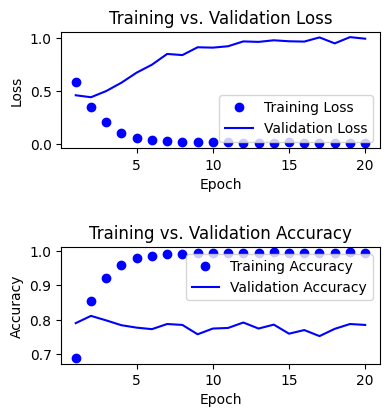

In [30]:
def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(5)
  fig.set_figwidth(5)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()
plot_train_vs_val_performance(history)

In [ ]:
# This classifies the tweets with 80% validation accuracy and 99% training accuracy.